In [37]:
##import libraries
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates as denormalize_coordinates

from filterpy.kalman import KalmanFilter
%matplotlib inline

In [38]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_facemesh = mp.solutions.face_mesh
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

In [39]:
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [40]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [41]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)
 
        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [42]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""
 
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

In [43]:
def get_mediapipe_app(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
 ):
    """Initialize and return Mediapipe FaceMesh Solution Graph object"""
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    )
 
    return face_mesh
 
def plot_eye_landmarks(frame, left_lm_coordinates, 
                       right_lm_coordinates, color
                       ):
    for lm_coordinates in [left_lm_coordinates, right_lm_coordinates]:
        if lm_coordinates:
            for coord in lm_coordinates:
                cv2.circle(frame, coord, 2, color, -1)
 
    frame = cv2.flip(frame, 1)
    return frame
 
 
def plot_text(image, text, origin, 
              color, font=cv2.FONT_HERSHEY_SIMPLEX, 
              fntScale=0.8, thickness=2
              ):
    image = cv2.putText(image, text, origin, font, fntScale, color, thickness)
    return image

In [8]:
class VideoFrameHandler:
    def __init__(self):
        """
        Initialize the necessary constants, mediapipe app
        and tracker variables
        """
        # Left and right eye chosen landmarks.
        self.eye_idxs = {
            "left": [362, 385, 387, 263, 373, 380],
            "right": [33, 160, 158, 133, 153, 144],
        }
 
        # Used for coloring landmark points.
        # Its value depends on the current EAR value.
        self.RED = (0, 0, 255)  # BGR
        self.GREEN = (0, 255, 0)  # BGR
 
        # Initializing Mediapipe FaceMesh solution pipeline
        self.facemesh_model = get_mediapipe_app()
 
        # For tracking counters and sharing states in and out of callbacks.
        self.state_tracker = {
            "start_time": time.perf_counter(),
            "DROWSY_TIME": 0.0,  # Holds time passed with EAR < EAR_THRESH
            "COLOR": self.GREEN,
            "play_alarm": False,
        }
 
        self.EAR_txt_pos = (10, 30)

In [44]:
def process(self, frame: np.array, thresholds: dict):
 
        # To improve performance,
        # mark the frame as not writeable to pass by reference.
        frame.flags.writeable = False
        frame_h, frame_w, _ = frame.shape
        DROWSY_TIME_txt_pos = (10, int(frame_h // 2 * 1.7))
        ALM_txt_pos = (10, int(frame_h // 2 * 1.85))
 
        results = self.facemesh_model.process(frame)
 
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            EAR, coordinates = calculate_avg_ear(landmarks,
                                                 self.eye_idxs["left"], 
                                                 self.eye_idxs["right"], 
                                                 frame_w, 
                                                 frame_h
                                                 )
            frame = plot_eye_landmarks(frame, 
                                       coordinates[0], 
                                       coordinates[1],
                                       self.state_tracker["COLOR"]
                                       )
 
            if EAR < thresholds["EAR_THRESH"]:
 
                # Increase DROWSY_TIME to track the time period with 
                # EAR less than the threshold
                # and reset the start_time for the next iteration.
                end_time = time.perf_counter()
 
                self.state_tracker["DROWSY_TIME"] += end_time - self.state_tracker["start_time"]
                self.state_tracker["start_time"] = end_time
                self.state_tracker["COLOR"] = self.RED
 
                if self.state_tracker["DROWSY_TIME"] >= thresholds["WAIT_TIME"]:
                    self.state_tracker["play_alarm"] = True
                    plot_text(frame, "WAKE UP! WAKE UP", 
                              ALM_txt_pos, self.state_tracker["COLOR"])
 
            else:
                self.state_tracker["start_time"] = time.perf_counter()
                self.state_tracker["DROWSY_TIME"] = 0.0
                self.state_tracker["COLOR"] = self.GREEN
                self.state_tracker["play_alarm"] = False
 
            EAR_txt = f"EAR: {round(EAR, 2)}"
            DROWSY_TIME_txt = f"DROWSY: {round(self.state_tracker['DROWSY_TIME'], 3)} Secs"
            plot_text(frame, EAR_txt, 
                      self.EAR_txt_pos, self.state_tracker["COLOR"])
            plot_text(frame, DROWSY_TIME_txt, 
                      DROWSY_TIME_txt_pos, self.state_tracker["COLOR"])
 
        else:
            self.state_tracker["start_time"] = time.perf_counter()
            self.state_tracker["DROWSY_TIME"] = 0.0
            self.state_tracker["COLOR"] = self.GREEN
            self.state_tracker["play_alarm"] = False
 
            # Flip the frame horizontally for a selfie-view display.
            frame = cv2.flip(frame, 1)
 
        return frame, self.state_tracker["play_alarm"]

In [45]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 

    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
    thickness=ts_thickness, 
    circle_radius=ts_circle_radius, 
    color=(255, 255, 255)
    )

    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")

    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                        pred_cord, 
                        lmk_circle_radius, 
                        (255, 255, 255), 
                        -1
                        )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                        pred_cord, 
                        lmk_circle_radius, 
                        (255, 255, 255), 
                        -1
                        )

    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

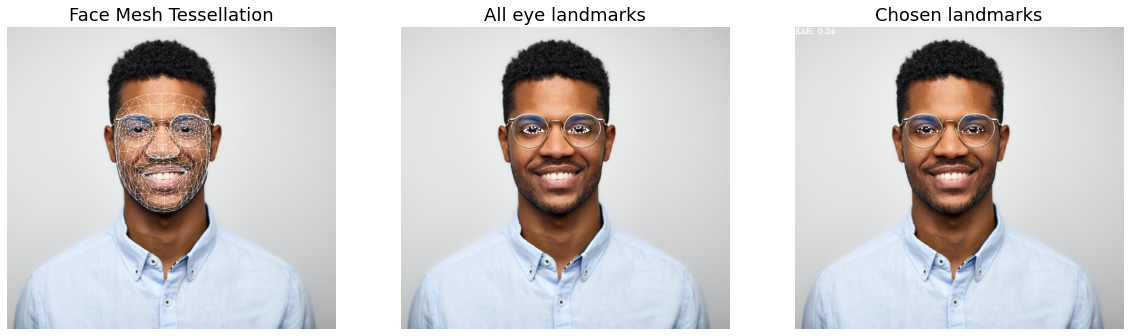

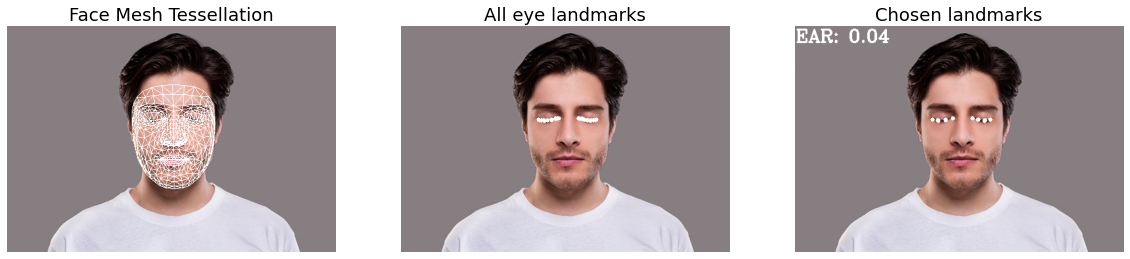

In [46]:
image_eyes_open  = cv2.imread("test-open-eyes.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("test-close-eyes.jpg")[:, :, ::-1]
 
for idx, image in enumerate([image_eyes_open, image_eyes_close]):
    
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
 
    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()
 
    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )
 
                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                
              
                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )

In [33]:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

cap = cv2.VideoCapture(0)

with mp_facemesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      continue
    
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)

    # Draw the face mesh annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:

        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_facemesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())

        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_facemesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
            
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_facemesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

    cv2.imshow('MediaPipe Face Mesh', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break

'''
    if results.face_landmarks:
      face_landmarks = results.face_landmarks
      face_data = update(face_landmarks)

      print(face_data["eye_aspect_ratio"]["left"], face_data["eye_aspect_ratio"]["right"])
'''

cap.release()

In [27]:
n_parameters = 11

def __init__(self):
    
        self.filter = KalmanFilter(dim_x=self.n_parameters*2, dim_z=self.n_parameters)
        self.filter.x = np.zeros(self.n_parameters*2)
        self.filter.F = np.identity(self.n_parameters*2)
        for i in range(self.n_parameters):
            self.filter.F[i, i+self.n_parameters] = 1
        self.filter.H \
            = np.concatenate((np.identity(self.n_parameters), np.zeros((self.n_parameters, self.n_parameters))), axis=1)

        # EAR
        self.filter.Q[6:8, 6:8] *= 0.1
        self.filter.Q[self.n_parameters+6:self.n_parameters+8, self.n_parameters+6:self.n_parameters+8] *= 0.1
        # MAR
        self.filter.Q[10:11, 10:11] *= 1
        self.filter.Q[self.n_parameters + 10:self.n_parameters + 11, self.n_parameters + 10:self.n_parameters + 11] *= 0.1

        
        # EAR
        self.filter.R[6:8, 6:8] *= 7
        # MAR
        self.filter.R[10:11, 10:11] *= 0.01

def update(self, face_landmarks):
        self.filter.predict()

        face_data = extract_data(face_landmarks)

        self.filter.update([
            face_data['eye_aspect_ratio']['left'],
            face_data['eye_aspect_ratio']['right'],
        ])
        
        face_data['eye_aspect_ratio']['left'], face_data['eye_aspect_ratio']['right']= self.filter.x[:self.n_parameters]
        
        return face_data


def extract_data(face_landmarks):
    face_data = {
        "eye_aspect_ratio": {
            "left": 0,
            "right": 0
        }        
    }

    landmarks = face_landmarks.landmark

    left_eye_landmarks = [
        landmarks[33],
        landmarks[159],
        landmarks[158],
        landmarks[133],
        landmarks[145]
    ]
    right_eye_landmarks = [
        landmarks[263],
        landmarks[386],
        landmarks[385],
        landmarks[362],
        landmarks[374]
    ]
    
    face_data["eye_aspect_ratio"]["left"], face_data["eye_aspect_ratio"]["right"] = eye_parameters(left_eye_landmarks, right_eye_landmarks)

    # face_data["mouth_aspect_ratio"] = mouth_aspect_ratio(mouth_landmarks)
    return face_data


In [49]:
def eye_parameters(left_eye_landmarks, right_eye_landmarks):

    eye_aspect_ratios = [None, None]

    for i, (eye_landmarks) in enumerate(zip(left_eye_landmarks, right_eye_landmarks)):
        
        outer, top_outer, top_inner, inner, bottom, iris \
            = map(lambda p: np.array([p.x, p.y, p.z]), (*eye_landmarks, iris))
        top = (top_outer + top_inner) / 2

        eye_aspect_ratios[i] = eye_aspect_ratio(outer, inner, top, bottom)
    
    return eye_aspect_ratios

In [48]:
# calculate eye aspect ratio
def eye_aspect_ratio(outer, inner, top, bottom):
    SCALING_FACTOR = 1
    return np.clip(np.linalg.norm(top - bottom) / np.linalg.norm(outer - inner) * SCALING_FACTOR, 0, 1)

In [47]:
if results.face_landmarks:
    face_landmarks = results.face_landmarks
    face_data = update(face_landmarks)

    print(face_data["eye_aspect_ratio"]["left"], face_data["eye_aspect_ratio"]["right"])

AttributeError: 'list' object has no attribute 'face_landmarks'